In [2]:
import os
import yaml
import numpy as np
from math import sqrt,log10
import pylab as plt
from scipy.optimize import brentq, fmin
from scipy.interpolate import interp1d as interp
from scipy.interpolate import UnivariateSpline as spline
from pymc import gelman_rubin
from corner import corner, hist2d

#from sklearn.model_selection import LeaveOneOut
%matplotlib inline

### script to extract results from log.txt file

# emcee

## all params

### 2D histogram of peak

In [71]:
from itertools import combinations

In [193]:
samples = np.load('../results/mcmc/samples_J1672_N10000.npy')
lnprobs = np.load('../results/mcmc/lnprobs_J1672_N10000.npy')
parameters = ['r', 'a', 'b', 'c']

In [194]:
flatsamples = samples[:, :, :].reshape( (-1, len(samples[0][0])) )
L = lnprobs.reshape(-1)
Lmax = max(L)
indLmax = np.where( L==Lmax )[0][0]
ind2Dhist = np.where( L>Lmax-0.1 )[0]
for p,param in enumerate( parameters ):
    values = flatsamples[:,p]
    exec( "{} = values".format(param) )
    exec( "{}_min = values[indLmax]".format(param) )
    #print param, min(values), max(values)

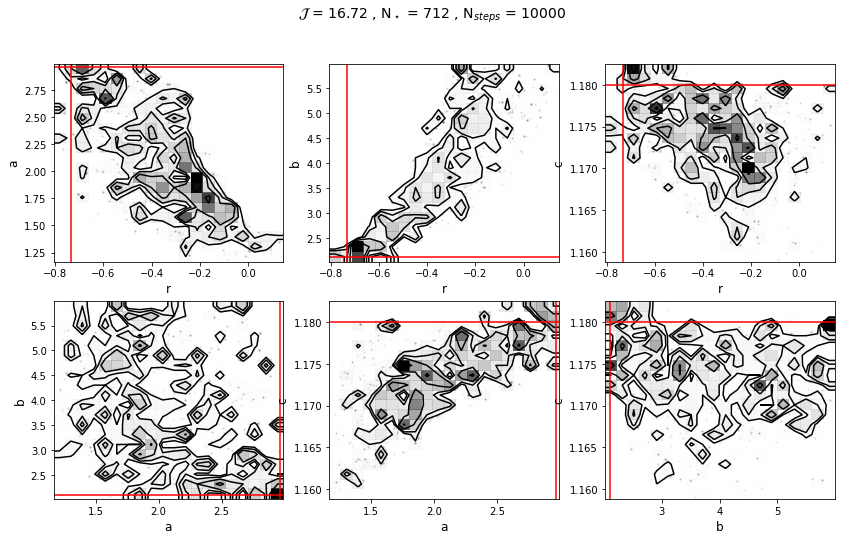

In [201]:
combs = combinations(range(4), 2)
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(14,8) )
for n,((i,j), ax) in enumerate( zip(combs, axes.flat) ):
    hist2d(x=flatsamples[ind2Dhist, i], y=flatsamples[ind2Dhist, j], ax=ax)
    ax.set_xlabel(parameters[i], fontsize=12);
    ax.set_ylabel(parameters[j], fontsize=12);
    ax.vlines(x=eval( '{}_min'.format(parameters[i]) ), 
              ymin=eval( 'min({})'.format(parameters[j]) ),
              ymax=eval( 'max({})'.format(parameters[j]) ),
              color='r')
    ax.hlines(y=eval( '{}_min'.format(parameters[j]) ), 
              xmin=eval( 'min({})'.format(parameters[i]) ),
              xmax=eval( 'max({})'.format(parameters[i]) ),
              color='r')
#plt.tight_layout();
plt.suptitle(r'$\mathcal{J}$ = 16.72 , N$_\star$ = 712 , N$_{steps}$ = 10000', fontsize=14);
#plt.savefig('../results/mcmc/2Dhists/2dhist_712s_J1672_N10000.png', dpi=300)

In [207]:
18.06*100

1805.9999999999998

In [205]:
Js = [14.02, 15.07, 16.04, 18.06]
parameters = ['r', 'a', 'b', 'c']
for J in Js:
    samples = np.load('../results/mcmc/emc_results/samples_100_J%i_N10000.npy'%(J*100))
    lnprobs = np.load('../results/mcmc/emc_results/lnprobs_100_J%i_N10000.npy'%(J*100))
    
    flatsamples = samples[:, :, :].reshape( (-1, len(samples[0][0])) )
    L = lnprobs.reshape(-1)
    Lmax = max(L)
    indLmax = np.where( L==Lmax )[0][0]
    ind2Dhist = np.where( L>Lmax-0.1 )[0]
    for p,param in enumerate( parameters ):
        values = flatsamples[:,p]
        exec( "{} = values".format(param) )
        exec( "{}_min = values[indLmax]".format(param) )
        #print param, min(values), max(values)
    
    combs = combinations(range(4), 2)
    fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(14,8) )
    for n,((i,j), ax) in enumerate( zip(combs, axes.flat) ):
        hist2d(x=flatsamples[ind2Dhist, i], y=flatsamples[ind2Dhist, j], ax=ax)
        ax.set_xlabel(parameters[i], fontsize=12);
        ax.set_ylabel(parameters[j], fontsize=12);
        ax.vlines(x=eval( '{}_min'.format(parameters[i]) ), 
                  ymin=eval( 'min({})'.format(parameters[j]) ),
                  ymax=eval( 'max({})'.format(parameters[j]) ),
                  color='r')
        ax.hlines(y=eval( '{}_min'.format(parameters[j]) ), 
                  xmin=eval( 'min({})'.format(parameters[i]) ),
                  xmax=eval( 'max({})'.format(parameters[i]) ),
                  color='r')
    #plt.tight_layout();
    plt.suptitle(r'$\mathcal{J}$ = %.2f , N$_\star$ = 100 , N$_{steps}$ = 10000'%J, fontsize=14);
    plt.savefig('../results/mcmc/2Dhists/2dhist_100s_J%i_N10000.png'%(J*100), dpi=300)
    plt.clf()
    plt.close()

IOError: [Errno 2] No such file or directory: '../results/mcmc/emc_results/samples_100_J1805_N10000.npy'

## test convergence - via Geman-Rubin criteria - as a function of Nsteps

In [364]:
path = '/home/andrea/Desktop/work/DWARF/ASTROJPY/results/mcmc/'
files = os.listdir(path+'emc_results/')
#samples_list = sorted( [f for f in files if 'samples_100' in f and 'N10000.npy' in f] )
#lnprobs_list = sorted( [f for f in files if 'lnprobs_100' in f and 'N10000.npy' in f] )
samples_list = sorted( [f for f in files if 'samples' in f and 'N5000.npy' in f] )
lnprobs_list = sorted( [f for f in files if 'lnprobs' in f and 'N5000.npy' in f] )

indJ = np.where(['J' in s for s in samples_list[1].split('_')])[0][0]

J = [float( j.split('_')[indJ].strip('J') )/100 for j in samples_list]
parameters = ['r', 'a', 'b', 'c']

For  
- N$_\star$ = 10, $\sim$ 1000 steps in the chain suffice
- N$_\star$ = 100, $\sim$ 2000 steps it's a better choice
- N$_\star$ = 712, $\sim$ 3000 steps should suffice to given $R\approx1$

## plot all plots for all Js

In [2]:
def myround(x, base=5):
    return int(base * round(float(x)/base))

## build profile

In [319]:
path = '/home/andrea/Desktop/work/DWARF/ASTROJPY/results/mcmc/'
files = os.listdir(path+'emc_results/')
samples = sorted( [f for f in files if 'samples_10s' in f and 'N10000.npy' in f] )
lnprobs = sorted( [f for f in files if 'lnprobs_10s' in f and 'N10000.npy' in f] )
#samples = sorted( [f for f in files if 'samples' in f and 'N5000.npy' in f] )
#lnprobs = sorted( [f for f in files if 'lnprobs' in f and 'N5000.npy' in f] )

J = [float( j.split('_')[2].strip('J') )/100 for j in samples]

In [320]:
for var in ['L', 'r', 'a', 'b', 'c']:
    exec( '{}_min = []'.format(var) )

for j,(pars_file, lnprobs_file) in enumerate( zip(samples, lnprobs) ):
    # open loglikelihoods
    llikes = np.load(path+'emc_results/'+lnprobs_file)
    L = -llikes.reshape(-1)
    Lmin = min(L)
    indLmin = np.where( L==Lmin )[0][-1]
    L_min.append( Lmin )
    
    # parameters
    params = np.load(path+'emc_results/'+pars_file)
    flatparams = params[:, :, :].reshape((-1, len(params[0][0])))
    for p,(par,R) in enumerate( zip( ['r', 'a', 'b', 'c'], gelman_rubin(params) ) ):
        #print par, round(R,3)
        values = [flatparams[i][p] for i in range(len(flatparams))]
        exec( "{} = np.asarray(values)".format(par) )
        exec( "{0}_min.append( {0}[indLmin] )".format(par) )

In [321]:
interpL = interp(J, L_min)
eval_Like_J = np.linspace(min(J), max(J), 1000)
min_Like_J = interpL(eval_Like_J).min()
Jmin = eval_Like_J[ np.where( interpL(eval_Like_J) == min_Like_J )[0][0] ]

In [322]:
for i,c in enumerate([0.5, 2.0, 4.5]):
    exec('J%ssL = %.2f'%(i+1, brentq(lambda j : interpL(j)-interpL(J).min()-c, min(J), Jmin) - Jmin))
    exec('J%ssR = %.2f'%(i+1, brentq(lambda j : interpL(j)-interpL(J).min()-c, Jmin, max(J)) - Jmin))

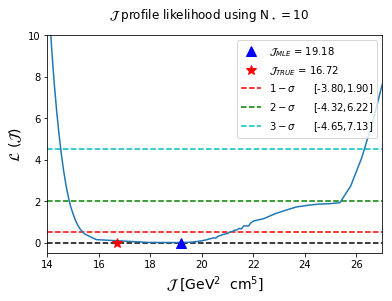

In [324]:
plt.plot(J, L_min-min(L_min));
plt.plot(Jmin, 0, 'b^', ms=10, label=r'$\mathcal{J}_{MLE}$ = %.2f'%Jmin);
plt.plot(16.72, 0, 'r*', ms=10, label=r'$\mathcal{J}_{TRUE}$ = 16.72');
plt.hlines(0, 14, 27, linestyles='dashed', colors='k');
for i,(c,h) in enumerate(zip(['r','g','c'],[0.5, 2.0, 4.5])):
    s = i+1
    JL, JR = eval( 'J{}sL'.format(s) ), eval( 'J{}sR'.format(s) )
    plt.hlines(h, 14, 27, linestyles='dashed', colors=c,
              label=r'$%i-\sigma$'%s+'\t'+'[%.2f,%.2f]'%(JL, JR))
plt.ylim(-0.5, 10);
plt.xlim(14, 27);
plt.xlabel(r'$\mathcal{J}$ [GeV$^2$  cm$^5$]', fontsize=14);
plt.ylabel(r'$\mathcal{L}$ ($\mathcal{J}$)', fontsize=14);
plt.legend(loc='upper right').get_frame().set_facecolor('w');
plt.suptitle(r'$\mathcal{J}$ profile likelihood using N$_\star = 10$');
#plt.savefig(path+'profileJ_10s.png', dpi=300);

# brute force

## L - r , a

In [77]:
samples = np.load('../results/mcmc/samples_Lra_J1672_N1000.npy')
lnprobs = np.load('../results/mcmc/lnprobs_Lra_J1672_N1000.npy')

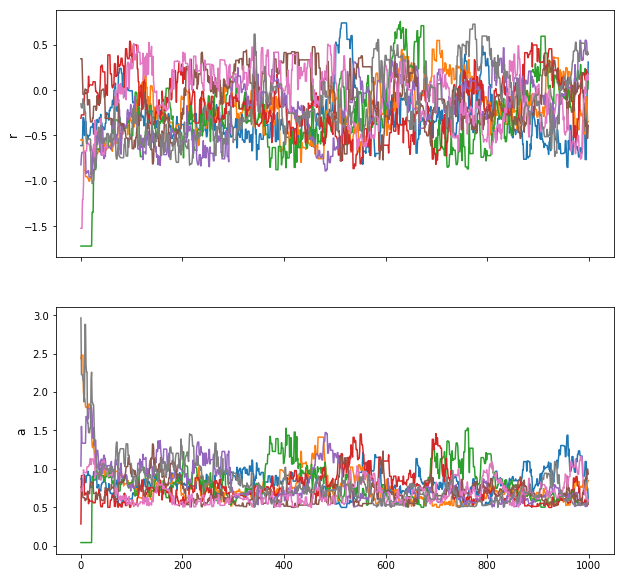

In [78]:
fig, axes = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(10,10))
steps = range(len(samples[0]))
for p,(par,ax) in enumerate(zip(['r', 'a'],axes)):
    for nw in range(len(samples)):
        vals = [samples[nw][i][p] for i in steps]
        ax.plot(steps, vals)
        ax.set_ylabel(par, fontsize=12);
#plt.savefig('../results/mcmc/chains_J1672_N10000.png', dpi=300)

In [79]:
pltsamples = samples[:, :, :].reshape((-1, len(samples[0][0])))

In [80]:
L = -lnprobs.reshape(-1)
Lmin = min(L)
indLmin = np.where( L==Lmin )[0][-1]
for p,par in enumerate(['r', 'a']):
    exec( "emc_{} = np.asarray([pltsamples[i][p] for i in range(len(pltsamples))])".format(par) )
    exec( '{0}_min = emc_{0}[indLmin]'.format(par) )

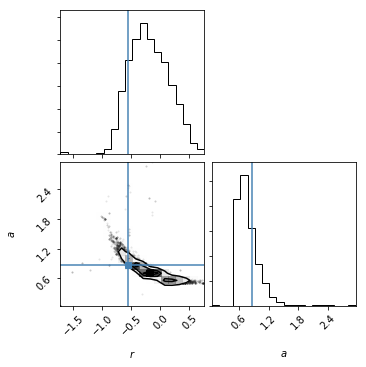

In [81]:
import corner
truep = [-0.55, 0.86]
minp = [r_min, a_min]
fig = corner.corner(pltsamples, labels=["$r$", "$a$"], truths=truep)
#plt.savefig('../results/mcmc/corner_Lra_J1672_N1000.png', dpi=300)

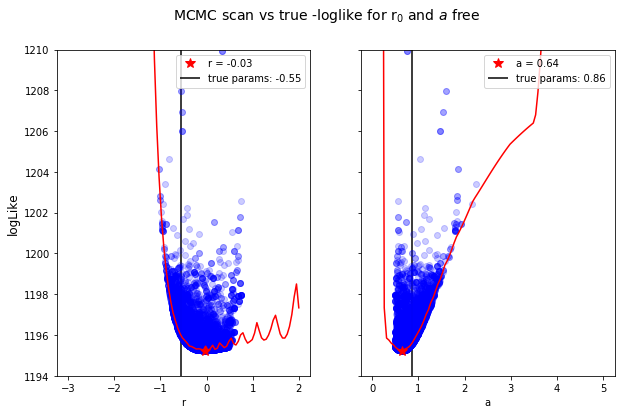

In [82]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,6), sharey=True)
for i,(par, ax) in enumerate(zip(['r', 'a'], axes.flat)):
    ax.plot( eval('emc_{}'.format(par)), L, 'bo', alpha=0.2  );
    exec( 'parmin = {}_min'.format(par) )
    ax.plot( parmin, Lmin, 'r*', ms=10, label= '%s = %.2f'%(par, parmin) );
    ax.vlines(x=truep[i], ymin=0, ymax=2000, label='true params: %.2f'%truep[i]);
    
    ax.plot( eval('bf_{}_arr'.format(par)), eval('bf_L{}_arr'.format(par)), c='r' )
    ax.set_xlabel(par);
    if i%2 == 0: 
        ax.set_ylabel('logLike', fontsize=12)
    ax.set_ylim(1194, 1210);
    ax.legend(numpoints=1, loc='upper right');
#plt.tight_layout()
plt.suptitle(r'MCMC scan vs true -loglike for r$_0$ and $a$ free', fontsize=14);
#plt.savefig('../results/mcmc/Lra100.png', dpi=300);

# PyMC

## determination of smoothing order via Leave-one-out cross-validation

In [61]:
min_splnmins = spline_mins(eval_Like_J).min()
Jminspl = eval_Like_J[ np.where( spline_mins(eval_Like_J) == min_splnmins )[0][0] ]

## plotting the true likelihood curve

# Minuit

In [148]:
J, L, a, b, c, r = np.load('../results/Minuit.npy')
linear_L = interp(J, L)

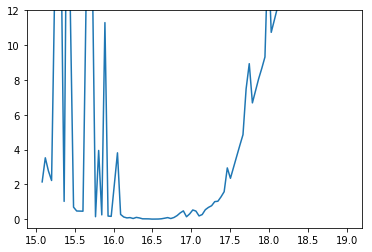

In [150]:
plt.plot(J, L-min(L));
plt.ylim(-0.5, 12);

In [69]:
eval_Like_J = np.linspace(J.min(), J.max(), 100)
min_Like_J = linear_L(eval_Like_J).min()
Jmin = eval_Like_J[ np.where( linear_L(eval_Like_J) == min_Like_J )[0][0] ]

In [70]:
for par in ['a', 'b', 'c', 'r']:
    exec( 'spl_{par} = interp(J, {par})'.format(par=par))
    exec( 'J{0} = float(spl_{0}(Jmin))'.format(par) )

In [71]:
for i,c in enumerate([0.5,2.0,4.5]):
    exec('J%ssL = %.2f'%(i+1, brentq(lambda j : linear_L(j)-linear_L(J).min()-c, J.min(), Jmin) - Jmin))
    exec('J%ssR = %.2f'%(i+1, brentq(lambda j : linear_L(j)-linear_L(J).min()-c, Jmin, J.max()) - Jmin))

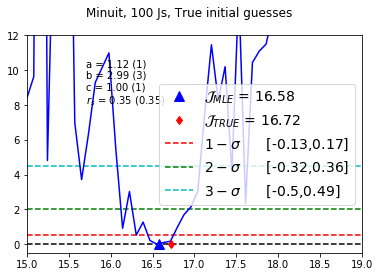

In [73]:
lin = linear_L(J)
plt.plot(J, lin-lin.min(), 'b');

plt.hlines(0, J.min(), J.max(), linestyles='dashed')
plt.plot(Jmin, 0, 'b^', markersize=10, label=r'$\mathcal{J}_{MLE}$ = %.2f'%Jmin)
plt.plot(16.72, 0, 'rd', markersize=6, label=r'$\mathcal{J}_{TRUE}$ = 16.72')
for i,(c,h) in enumerate(zip(['r','g','c'],[0.5,2.0,4.5])):
    JL, JR = eval('J%ssL'%str(i+1)), eval('J%ssR'%str(i+1))
    plt.hlines(h, J.min(), J.max(), linestyles='dashed', colors=c,
              label=r'$%i-\sigma$'%(i+1)+'\t'+'[%2s,%2s]'%(str(JL),str(JR)))
plt.legend(numpoints=1,fontsize=14).get_frame().set_facecolor('w')
plt.text(15.7, 8,'a = %.2f (1)'%Ja +'\n'+
                 'b = %.2f (3)'%Jb +'\n'+
                 'c = %.2f (1)'%Jc +'\n'+
                 r'$r_s$ = %.2f (0.35)'%Jr)

plt.ylim(-0.5,12);
plt.xlim(15, 19);
plt.suptitle('Minuit, 100 Js, True initial guesses');
#plt.savefig('results/LikeJ_Min_rabc_100p_Tini_lin.png',format='png',dpi=300);